In [122]:
#import libraries
import streamlit as st

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import time, date, datetime
from thefuzz import fuzz
import openpyxl
from openpyxl import Workbook

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

# Instruction
1. Jump to "Data Wrangling" function

## A. Data Cleaning

**Raw CFU** file is a template. To write a function:
- skiprows=2
- key: 'Batch' col
- features: [Sample description],'Storage form','Temperature (C)','T0','Date','CFU/mL','CFU/g','CV' (?),'Water Acitivty' cols
- remove rows with NaN in 'Batch' col
- Change 'Batch' col to 'FD Run ID'

- Change to datetime for "Date, T0"
- Change to float/number for "CFU/mL, CFU/g, CV": fix DIV/0 to NaN

In [3]:
# Import the dataset
rawcfu_df = pd.read_csv(filepath_or_buffer="/Users/miu/IFF_st/Data files/InPack_CFU_Test.csv")
rawcfu_df.head()

,"Sparkle PIVOT Sample CFU plating data recording sheet. Manually enter your data in columns marked with a ⭐ (optional: †) and the other columns should auto-calculate appropriately. The data are sortable, and can be filtered using the dropdowns in each column.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,⭐,⭐,†,†,†,⭐,†,⭐,NaN,⭐,...,†,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⭐
1,Batch,Sample Description,Storage form,Temperature-Celsius,Logs,No. Reps,Extra,grams,mL,Who,...,R3,CFU/mL,SD CFU/mL,Extender CFU/mL,Extender CFU/mL SD,CFU/g,SD CFU/g,CV,Water Activity,Remark/AW
2,IFF09152022-2 T1,NaN,NaN,21,"5, 6",3,NaN,0.3,5.7,EC,...,172,7.41E+08,6.38E+07,NaN,NaN,1.41E+10,1.21E+09,8.60%,0.254,"SP-SDS, Water Activity= 0.254"
3,IFF09152022-2 T2,NaN,NaN,21,"5, 6",3,NaN,0.3,5.7,EC,...,46,1.97E+09,1.97E+08,NaN,NaN,3.75E+10,3.75E+09,10.00%,0.198,"SP-SDS, Water Activity= 0.198"
4,IFF09152022-2 T3,NaN,NaN,4,"6, 7",3,NaN,0.3,5.7,EC,...,35,1.25E+10,2.54E+09,NaN,NaN,2.38E+11,4.83E+10,20.30%,NaN,Redo


In [4]:
# replace the colmns with the values of the second row
rawcfu_df.columns = rawcfu_df.iloc[1]

# remove the first and second rows
rawcfu_df = rawcfu_df.iloc[2:]

# reset index
rawcfu_df = rawcfu_df.reset_index()

# keep relevant cols
rawcfu_df = rawcfu_df[['Batch','Sample Description','Storage form','Temperature (C)',
                       'T0','Date','CFU/mL','CFU/g','Extender CFU/mL','Extender CFU/mL SD',
                       'CV','Water Activity']]

rawcfu_df.head()

1,Batch,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,Extender CFU/mL,Extender CFU/mL SD,CV,Water Activity
0,IFF09152022-2 T1,NaN,NaN,21,1/5/23,2/27/23,7.41E+08,1.41E+10,NaN,NaN,8.60%,0.254
1,IFF09152022-2 T2,NaN,NaN,21,1/5/23,2/27/23,1.97E+09,3.75E+10,NaN,NaN,10.00%,0.198
2,IFF09152022-2 T3,NaN,NaN,4,1/5/23,2/27/23,1.25E+10,2.38E+11,NaN,NaN,20.30%,NaN
3,IFF09152022-2 T3,NaN,NaN,4,1/5/23,3/1/23,2.30E+01,4.50E+00,NaN,NaN,8.60%,NaN
4,IFF09152022-2 T4,NaN,NaN,21,1/5/23,2/27/23,4.55E+08,8.64E+09,NaN,NaN,7.90%,0.267


In [5]:
rawcfu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Batch                72 non-null     object
 1   Sample Description   13 non-null     object
 2   Storage form         23 non-null     object
 3   Temperature-Celsius  17 non-null     object
 4   T0                   72 non-null     object
 5   Date                 72 non-null     object
 6   CFU/mL               71 non-null     object
 7   CFU/g                72 non-null     object
 8   Extender CFU/mL      9 non-null      object
 9   Extender CFU/mL SD   9 non-null      object
 10  CV                   72 non-null     object
 11  Water Activity       14 non-null     object
dtypes: object(12)
memory usage: 7.2+ KB


<Axes: xlabel='1'>

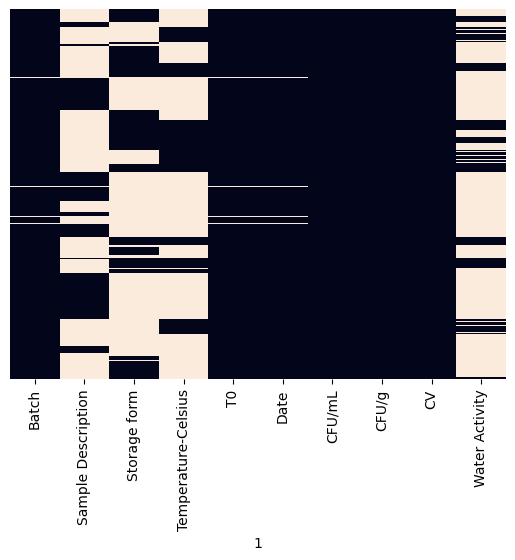

In [5]:
# check NaN values
sns.heatmap(rawcfu_df.isnull(), yticklabels=False, cbar=False)

(401, 10)

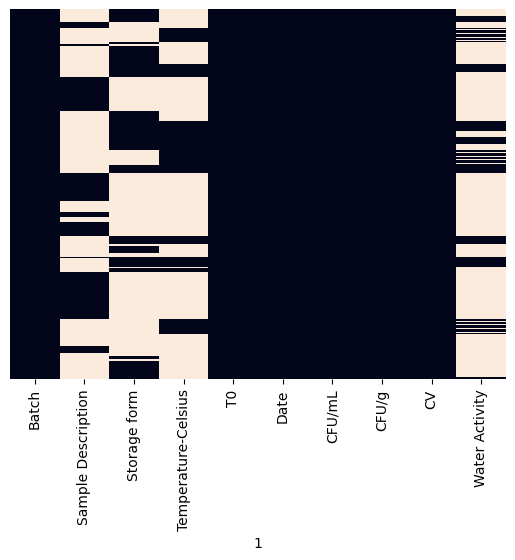

In [6]:
# remove rows with NaN in 'Batch" col
rawcfu_df.dropna(subset=['Batch'],inplace=True)
sns.heatmap(rawcfu_df.isnull(), yticklabels=False, cbar=False)
rawcfu_df.shape

# NaN in CFU/mL or CFU/g indicate either the samples in liq or sol form

In [7]:
rawcfu_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401 entries, 0 to 404
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Batch                401 non-null    object
 1   Sample Description   154 non-null    object
 2   Storage form         157 non-null    object
 3   Temperature-Celsius  128 non-null    object
 4   T0                   401 non-null    object
 5   Date                 401 non-null    object
 6   CFU/mL               401 non-null    object
 7   CFU/g                401 non-null    object
 8   CV                   401 non-null    object
 9   Water Activity       101 non-null    object
dtypes: object(10)
memory usage: 34.5+ KB


In [8]:
# convert to datetime for T0 and Date
rawcfu_df[['T0','Date']] = rawcfu_df[['T0','Date']].apply(pd.to_datetime, format="%m/%d/%y")

In [9]:
rawcfu_df.head()

1,Batch,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV,Water Activity
0,FDL-105B-T05,NaN,Pellet,NaN,2023-01-03,2023-01-03,2.14E+09,4.07E+10,27.80%,NaN
1,FDL-105B-T06,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.52E+09,6.69E+10,4.80%,NaN
2,FDL-105B-T07,NaN,Pellet,NaN,2023-01-03,2023-01-03,1.58E+10,3.00E+11,1.80%,NaN
3,FDL-105B-T09,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.10E+09,5.89E+10,13.70%,NaN
4,FDL-105B-T10,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.36E+10,6.38E+11,10.10%,NaN


In [10]:
# calculate the time point of plating
## the difference 'Date'-'T0' is a 'timedelta'
rawcfu_df['Time point (day)'] = (rawcfu_df['Date']-rawcfu_df['T0']).apply(lambda x: x.days)
rawcfu_df.head()

1,Batch,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV,Water Activity,Time point (day)
0,FDL-105B-T05,NaN,Pellet,NaN,2023-01-03,2023-01-03,2.14E+09,4.07E+10,27.80%,NaN,0
1,FDL-105B-T06,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.52E+09,6.69E+10,4.80%,NaN,0
2,FDL-105B-T07,NaN,Pellet,NaN,2023-01-03,2023-01-03,1.58E+10,3.00E+11,1.80%,NaN,0
3,FDL-105B-T09,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.10E+09,5.89E+10,13.70%,NaN,0
4,FDL-105B-T10,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.36E+10,6.38E+11,10.10%,NaN,0


In [11]:
# calculate time point in week
## cant' call .days or .week on timedelta. 
## So, I have to convert each dat to week of the year first before calculating the difference
to_week = rawcfu_df[['T0','Date']]

In [12]:
rawcfu_df['Date'].iloc[0].week - rawcfu_df['T0'].iloc[0].week

0

In [13]:
to_week.columns

Index(['T0', 'Date'], dtype='object', name=1)

In [14]:
for i in to_week.columns:
    to_week[i] = to_week[i].apply(lambda x:x.week)

In [15]:
rawcfu_df['Time point (week)'] = to_week['Date'] - to_week['T0']

In [16]:
rawcfu_df.head()

1,Batch,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV,Water Activity,Time point (day),Time point (week)
0,FDL-105B-T05,NaN,Pellet,NaN,2023-01-03,2023-01-03,2.14E+09,4.07E+10,27.80%,NaN,0,0
1,FDL-105B-T06,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.52E+09,6.69E+10,4.80%,NaN,0,0
2,FDL-105B-T07,NaN,Pellet,NaN,2023-01-03,2023-01-03,1.58E+10,3.00E+11,1.80%,NaN,0,0
3,FDL-105B-T09,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.10E+09,5.89E+10,13.70%,NaN,0,0
4,FDL-105B-T10,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.36E+10,6.38E+11,10.10%,NaN,0,0


In [17]:
# Change data type of CFU/mL 
rawcfu_df['CFU/mL'] = rawcfu_df['CFU/mL'].astype(float)

In [18]:
# invalid values (not scientific) in CFU/g col
rawcfu_df.loc[rawcfu_df['CFU/g'] == '#DIV/0!'].index

Int64Index([ 75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
            ...
            330, 331, 332, 333, 334, 335, 336, 337, 338, 339],
           dtype='int64', length=139)

In [19]:
# replace invalid values with NaN
rawcfu_df['CFU/g'] = rawcfu_df['CFU/g'].replace('#DIV/0!', np.NaN)

In [20]:
# Change data type of CFU/g to float
rawcfu_df['CFU/g'] = rawcfu_df['CFU/g'].astype(float)

In [21]:
# Change data type of CV to float
## convert each value to float without the % sign and ignore invalid values
for idx, row in rawcfu_df.iterrows():
    try:
        rawcfu_df.loc[idx, "CV"] = float(row['CV'].split("%")[0])
    except Exception as e:
        pass

In [22]:
## replace invalid values with NaN
rawcfu_df['CV'] = rawcfu_df['CV'].replace('#DIV/0!', np.NaN)

In [23]:
rawcfu_df

1,Batch,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV,Water Activity,Time point (day),Time point (week)
0,FDL-105B-T05,NaN,Pellet,NaN,2023-01-03,2023-01-03,2.140000e+09,4.070000e+10,27.8,NaN,0,0
1,FDL-105B-T06,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.520000e+09,6.690000e+10,4.8,NaN,0,0
2,FDL-105B-T07,NaN,Pellet,NaN,2023-01-03,2023-01-03,1.580000e+10,3.000000e+11,1.8,NaN,0,0
3,FDL-105B-T09,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.100000e+09,5.890000e+10,13.7,NaN,0,0
4,FDL-105B-T10,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.360000e+10,6.380000e+11,10.1,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
400,EDKOKO02222302,NaN,Bulked powder,NaN,2023-04-07,2023-04-07,3.560000e+08,6.760000e+09,13.2,NaN,0,0
401,FDL-105K-T42,NaN,Bulked powder,NaN,2023-04-07,2023-04-07,4.030000e+08,7.650000e+09,10.3,NaN,0,0
402,FDL-105K-T44,NaN,Bulked powder,NaN,2023-04-07,2023-04-07,1.130000e+08,2.150000e+09,1.7,NaN,0,0
403,FDL-105EF-T24 TMC1,NaN,Bulked powder,NaN,2023-04-07,2023-04-07,1.570000e+09,2.990000e+10,4.8,0.298,0,0


<Axes: xlabel='1'>

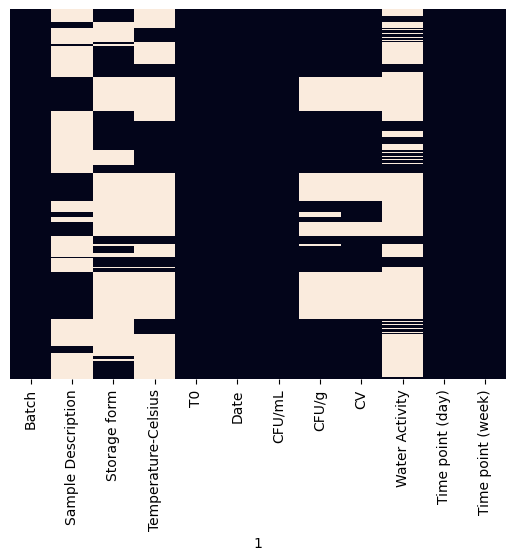

In [24]:
sns.heatmap(rawcfu_df.isnull(), yticklabels=False, cbar=False)

In [25]:
rawcfu_df.info()
# Keep Temp in str for visualization purpose

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401 entries, 0 to 404
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Batch                401 non-null    object        
 1   Sample Description   154 non-null    object        
 2   Storage form         157 non-null    object        
 3   Temperature-Celsius  128 non-null    object        
 4   T0                   401 non-null    datetime64[ns]
 5   Date                 401 non-null    datetime64[ns]
 6   CFU/mL               401 non-null    float64       
 7   CFU/g                262 non-null    float64       
 8   CV                   269 non-null    float64       
 9   Water Activity       101 non-null    object        
 10  Time point (day)     401 non-null    int64         
 11  Time point (week)    401 non-null    int64         
dtypes: datetime64[ns](2), float64(3), int64(2), object(5)
memory usage: 56.9+ KB


In [26]:
# Change Water Activity to float
rawcfu_df['Water Activity'] = rawcfu_df['Water Activity'].astype(float)

In [27]:
# Change col names
rawcfu_df.rename(columns={'Batch':'FD Run ID', 'CV':'CV (%)'}, inplace=True)
rawcfu_df.head()

1,FD Run ID,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV (%),Water Activity,Time point (day),Time point (week)
0,FDL-105B-T05,NaN,Pellet,NaN,2023-01-03,2023-01-03,2.140000e+09,4.070000e+10,27.8,NaN,0,0
1,FDL-105B-T06,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.520000e+09,6.690000e+10,4.8,NaN,0,0
2,FDL-105B-T07,NaN,Pellet,NaN,2023-01-03,2023-01-03,1.580000e+10,3.000000e+11,1.8,NaN,0,0
3,FDL-105B-T09,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.100000e+09,5.890000e+10,13.7,NaN,0,0
4,FDL-105B-T10,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.360000e+10,6.380000e+11,10.1,NaN,0,0


In [28]:
rawcfu_df.rename(columns={'Temperature (C)':'Temperature (C)'}, inplace=True)
rawcfu_df.head()

1,FD Run ID,Sample Description,Storage form,Temperature (C),T0,Date,CFU/mL,CFU/g,CV (%),Water Activity,Time point (day),Time point (week)
0,FDL-105B-T05,NaN,Pellet,NaN,2023-01-03,2023-01-03,2.140000e+09,4.070000e+10,27.8,NaN,0,0
1,FDL-105B-T06,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.520000e+09,6.690000e+10,4.8,NaN,0,0
2,FDL-105B-T07,NaN,Pellet,NaN,2023-01-03,2023-01-03,1.580000e+10,3.000000e+11,1.8,NaN,0,0
3,FDL-105B-T09,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.100000e+09,5.890000e+10,13.7,NaN,0,0
4,FDL-105B-T10,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.360000e+10,6.380000e+11,10.1,NaN,0,0


### Data cleaning steps

In [ ]:
# Import the dataset
rawcfu_df = pd.read_csv(filepath_or_buffer="/Users/miu/IFF_st/Data files/InPack_CFU_Test.csv")

In [3]:
# replace the colmns with the values of the second row
rawcfu_df.columns = rawcfu_df.iloc[1]
# remove the first and second rows
rawcfu_df = rawcfu_df.iloc[2:]
# reset index
rawcfu_df = rawcfu_df.reset_index()
# keep relevant cols
rawcfu_df = rawcfu_df[['Batch','Sample Description','Storage form','Temperature (C)',
                       'T0','Date','CFU/mL','CFU/g','Extender CFU/mL','Extender CFU/mL SD',
                       'CV','Water Activity']]
# remove rows with NaN in 'Batch" col
rawcfu_df.dropna(subset=['Batch'],inplace=True)


# convert to datetime for T0 and Date
rawcfu_df[['T0','Date']] = rawcfu_df[['T0','Date']].apply(pd.to_datetime, format="%m/%d/%y")

# calculate the time point of plating
## by days
rawcfu_df['Time point (day)'] = (rawcfu_df['Date']-rawcfu_df['T0']).apply(lambda x: x.days)
## by weeks   
def num_weeks(row):
        year1, week1, day1 = row['T0'].isocalendar()
        year2, week2, day2 = row['Date'].isocalendar()
        return (year2 - year1) * 52 + (week2 - week1)

# apply the function to each row of the DataFrame
rawcfu_df['Time point (week)'] = rawcfu_df.apply(num_weeks, axis=1)

# remove percentage sign for CV values while ignoring invalid values
for idx, row in rawcfu_df.iterrows():
    try:
        rawcfu_df.loc[idx, "CV"] = float(row['CV'].split("%")[0])
    except Exception as e:
        pass

# handle invalid values and change to float
to_float = rawcfu_df[['CFU/mL','CFU/g','Water Activity']]
for col in to_float.columns:
    rawcfu_df[col] = rawcfu_df[col].replace('#DIV/0!', np.NaN)
    rawcfu_df[col] = rawcfu_df[col].astype(float)
    
    
# Change col names
rawcfu_df.rename(columns={'Batch':'FD Run ID', 'Temperature (C)':'Temperature (C)', 'CV':'CV (%)'}, inplace=True)

In [4]:
rawcfu_df.head()

1,FD Run ID,Sample Description,Storage form,Temperature (C),T0,Date,CFU/mL,CFU/g,CV (%),Water Activity,Time point (day),Time point (week)
0,IFF09152022-2 T1,NaN,NaN,21,2023-01-05,2023-02-27,7.410000e+08,1.410000e+10,8.6,0.254,53,8
1,IFF09152022-2 T2,NaN,NaN,21,2023-01-05,2023-02-27,1.970000e+09,3.750000e+10,10.0,0.198,53,8
2,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-02-27,1.250000e+10,2.380000e+11,20.3,NaN,53,8
3,IFF09152022-2 T4,NaN,NaN,21,2023-01-05,2023-02-27,4.550000e+08,8.640000e+09,7.9,0.267,53,8
4,IFF09152022-3 T1,NaN,NaN,21,2023-01-05,2023-02-27,2.440000e+08,4.640000e+09,4.3,0.227,53,8


In [5]:
rawcfu_df.shape

(65, 12)

In [6]:
rawcfu_df['FD Run ID'].nunique()

61

## B. Data Processing

One sample can be in different storage form: bulk powder, pellet. Each will have a unique 'FD Run ID'
- **ISSUE: Naming for unique ID**
    Each 'FD Run ID' is not unique because:
    - one sample is submitted to different temperatures
    - one sample is stored in different form
- Arrange the CFU of each sample by Timepoint (week) (axis =1) (pivot table)
- Join new CFU data for each time point, axis =1
    - make sure there are only unique IDs (aka shape of pivot table)
    - remove 'T0','Date','CV' from rawcfu_df becasue it they make the some samples carry distinguish info (e.g. one sample with W0, W8 but different CV and Date -> the rows stay

In [83]:
# Record the CFUs by week for each ID
pivot_rawcfu = rawcfu_df.pivot(index='FD Run ID', columns='Time point (week)', values=['CFU/mL','CFU/g'])

In [84]:
pivot_rawcfu

CFU/mL                           CFU/g      \
Time point (week)               0   1             8             0   1   
FD Run ID                                                               
ABKLUB 030823AA      2.120000e+10 NaN           NaN  4.030000e+11 NaN   
ABKLUB 031023AA      2.250000e+10 NaN           NaN  4.280000e+11 NaN   
ABKLUB 031323AA      2.400000e+10 NaN           NaN  4.560000e+11 NaN   
ABKLUB 031623AA #9   2.960000e+10 NaN           NaN  5.620000e+11 NaN   
ABKLUB 031823AA #10  2.530000e+10 NaN           NaN  4.810000e+11 NaN   
...                           ...  ..           ...           ...  ..   
IFF10202022-1 T4              NaN NaN  7.170000e+07           NaN NaN   
IFF10202022-2 T1              NaN NaN  7.730000e+06           NaN NaN   
IFF10202022-2 T2              NaN NaN  1.050000e+07           NaN NaN   
IFF10202022-2 T3              NaN NaN  2.730000e+09           NaN NaN   
IFF10202022-2 T4              NaN NaN  4.130000e+06           NaN NaN   

                                   
Time point (week)               8  
FD Run ID                          
ABKLUB 030823AA               NaN  
ABKLUB 031023AA               NaN  
ABKLUB 031323AA               NaN  
ABKLUB 031623AA #9            NaN  
ABKLUB 031823AA #10           NaN  
...                           ...  
IFF10202022-1 T4     1.360000e+09  
IFF10202022-2 T1     1.470000e+08  
IFF10202022-2 T2     2.000000e+08  
IFF10202022-2 T3     5.190000e+10  
IFF10202022-2 T4     7.850000e+07  

[61 rows x 6 columns]

In [ ]:
# write to excel. Gives expected format
pivot_rawcfu.to_excel('CFU_cleaned.xlsx')

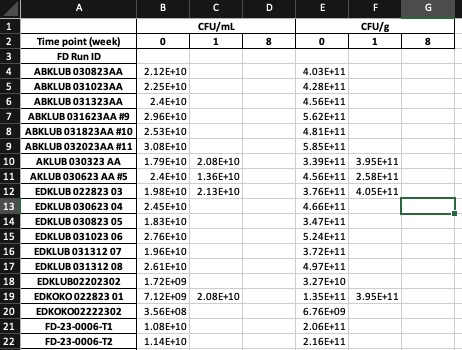

In [28]:
pivot_rawcfu.loc['AKLUB 030323 AA']

        Time point (week)
CFU/mL  0                    1.790000e+10
        1                    2.080000e+10
        8                             NaN
CFU/g   0                    3.390000e+11
        1                    3.950000e+11
        8                             NaN
Name: AKLUB 030323 AA, dtype: float64

In [29]:
pivot_rawcfu.columns.to_list()

[('CFU/mL', 0),
 ('CFU/mL', 1),
 ('CFU/mL', 8),
 ('CFU/g', 0),
 ('CFU/g', 1),
 ('CFU/g', 8)]

In [85]:
# rename the column by the counting week
pivot_rawcfu.columns = [f"W{week}_{scale}" for scale, week in pivot_rawcfu.columns.to_list()]

In [100]:
# remove cols that cause repeated samples
cfu = rawcfu_df.drop(['T0','Date','CFU/mL','CFU/g','CV (%)','Time point (day)','Time point (week)'],axis=1)

In [101]:
cfu.head()

1,FD Run ID,Sample Description,Storage form,Temperature (C),Water Activity
0,IFF09152022-2 T1,NaN,NaN,21,0.254
1,IFF09152022-2 T2,NaN,NaN,21,0.198
2,IFF09152022-2 T3,NaN,NaN,4,NaN
3,IFF09152022-2 T4,NaN,NaN,21,0.267
4,IFF09152022-3 T1,NaN,NaN,21,0.227


In [102]:
cfu.shape, pivot_rawcfu.shape

((65, 5), (61, 6))

In [103]:
cfu[cfu.duplicated('FD Run ID')]

1,FD Run ID,Sample Description,Storage form,Temperature (C),Water Activity
25,AKLUB 030623 AA #5,NaN,NaN,NaN,NaN
26,AKLUB 030323 AA,NaN,NaN,NaN,NaN
27,EDKOKO 022823 01,NaN,NaN,NaN,NaN
28,EDKLUB 022823 03,NaN,NaN,NaN,NaN


In [104]:
cfu.drop_duplicates(subset='FD Run ID', inplace=True)

In [105]:
cfu.shape

(61, 5)

In [106]:
joined_df = pd.merge(cfu, pivot_rawcfu, on='FD Run ID')

In [107]:
joined_df.head()

,FD Run ID,Sample Description,Storage form,Temperature (C),Water Activity,W0_CFU/mL,W1_CFU/mL,W8_CFU/mL,W0_CFU/g,W1_CFU/g,W8_CFU/g
0,IFF09152022-2 T1,NaN,NaN,21,0.254,NaN,NaN,7.410000e+08,NaN,NaN,1.410000e+10
1,IFF09152022-2 T2,NaN,NaN,21,0.198,NaN,NaN,1.970000e+09,NaN,NaN,3.750000e+10
2,IFF09152022-2 T3,NaN,NaN,4,NaN,NaN,NaN,1.250000e+10,NaN,NaN,2.380000e+11
3,IFF09152022-2 T4,NaN,NaN,21,0.267,NaN,NaN,4.550000e+08,NaN,NaN,8.640000e+09
4,IFF09152022-3 T1,NaN,NaN,21,0.227,NaN,NaN,2.440000e+08,NaN,NaN,4.640000e+09


In [108]:
joined_df.shape

(61, 11)

In [109]:
rawcfu_df.shape, pivot_rawcfu.shape, joined_df.shape

((65, 12), (61, 6), (61, 11))

The key information from this table is:
- FD Run ID: these must be unique and implemented soon for the program to work properly
- CFUs by weeks 

It's possible for the CFUs data to collected in 1 file as the df will be replaced and updated each time. The code will work as expected without concatenating the new info. 

The next steps are to:
- join this table to the master list
- relate to on-seed samples
- relate to sample information sheet (?)

### Data Processing Step

In [7]:
# Record the CFUs by week for each ID
pivot_rawcfu = rawcfu_df.pivot(index='FD Run ID', columns='Time point (week)', values=['CFU/mL','CFU/g'])
# rename the column by the counting week
pivot_rawcfu.columns = [f"W{week}_{scale}" for scale, week in pivot_rawcfu.columns.to_list()]

# remove cols that cause repeated samples
cfu = rawcfu_df.drop(['T0','Date','CFU/mL','CFU/g','CV (%)','Time point (day)','Time point (week)'],axis=1)
# drop duplicated IDs
cfu.drop_duplicates(subset='FD Run ID', inplace=True)

# join the pivot df with the original info
cleaned_cfu = pd.merge(cfu, pivot_rawcfu, on='FD Run ID')

In [8]:
cleaned_cfu.head()

,FD Run ID,Sample Description,Storage form,Temperature (C),Water Activity,W0_CFU/mL,W1_CFU/mL,W8_CFU/mL,W0_CFU/g,W1_CFU/g,W8_CFU/g
0,IFF09152022-2 T1,NaN,NaN,21,0.254,NaN,NaN,7.410000e+08,NaN,NaN,1.410000e+10
1,IFF09152022-2 T2,NaN,NaN,21,0.198,NaN,NaN,1.970000e+09,NaN,NaN,3.750000e+10
2,IFF09152022-2 T3,NaN,NaN,4,NaN,NaN,NaN,1.250000e+10,NaN,NaN,2.380000e+11
3,IFF09152022-2 T4,NaN,NaN,21,0.267,NaN,NaN,4.550000e+08,NaN,NaN,8.640000e+09
4,IFF09152022-3 T1,NaN,NaN,21,0.227,NaN,NaN,2.440000e+08,NaN,NaN,4.640000e+09


In [9]:
cleaned_cfu.shape

(61, 11)

In [ ]:
cleaned_cfu.to_excel('CFU_cleaned.xlsx')

## Data Wrangling Function

In [2]:
def pivot_in_pack(df):
    rawcfu_df = df
    rawcfu_df.columns = rawcfu_df.iloc[1]
    rawcfu_df = rawcfu_df.iloc[2:]
    rawcfu_df = rawcfu_df.reset_index()
    # remove rows with NaN in 'Batch" col
    rawcfu_df.dropna(subset=['Batch'],inplace=True)
    # remove rows with 'Redo' in 'Remark' col
    rawcfu_df.drop(rawcfu_df[rawcfu_df['Remark/AW'] == 'Redo'].index, inplace=True)
    # keep relevant cols
    rawcfu_df = rawcfu_df[['Batch','Sample Description','Storage form','Temperature-Celsius',
                           'T0','Date','CFU/mL','CFU/g', 'CV','Water Activity']]
    
    # convert to datetime for T0 and Date
    rawcfu_df[['T0','Date']] = rawcfu_df[['T0','Date']].apply(pd.to_datetime, format="%m/%d/%y")
    
    # calculate the time point by days and weeks of plating
    ## by days
    rawcfu_df['Time point (day)'] = np.absolute((rawcfu_df['Date']-rawcfu_df['T0'])).apply(lambda x: x.days)
    ## by weeks
    #df['Time point (week)'] = df['T0'].apply(lambda x: x.week) - df['Date'].apply(lambda x: x.week)
    def num_weeks(row):
        year1, week1, day1 = row['T0'].isocalendar()
        year2, week2, day2 = row['Date'].isocalendar()
        return (year2 - year1) * 52 + (week2 - week1)

    # apply the function to each row of the DataFrame
    rawcfu_df['Time point (week)'] = rawcfu_df.apply(num_weeks, axis=1)    
    
    # remove percentage sign for CV values while ignoring invalid values
    for idx, row in rawcfu_df.iterrows():
        try:
            rawcfu_df.loc[idx, "CV"] = float(row['CV'].split("%")[0])
        except Exception as e:
            pass
    
    # handle invalid values and change to float
    to_float = rawcfu_df[['CFU/mL','CFU/g','Water Activity']]
    for col in to_float.columns:
        rawcfu_df[col] = rawcfu_df[col].replace('#DIV/0!', np.NaN)
        rawcfu_df[col] = rawcfu_df[col].astype(float)      
        
    # change col names
    rawcfu_df.rename(columns={'Batch':'FD Run ID', 'CV':'CV (%)'}, inplace=True)
    
    # Record the CFUs by week for each ID
    pivot_rawcfu = rawcfu_df.pivot(
        index='FD Run ID', columns='Time point (week)',
        values=['CFU/mL','CFU/g','Water Activity'])
    # rename the column by the counting week
    pivot_rawcfu.columns = [f"W{week}_{scale}" for scale, week in pivot_rawcfu.columns.to_list()]
    
    # remove cols that cause repeated samples
    cfu = rawcfu_df.drop(['Sample Description','Storage form','Temperature-Celsius',
                          'CFU/mL','CFU/g','CV (%)','Water Activity','Time point (day)','Time point (week)'],axis=1)
    # drop duplicated IDs
    cfu.drop_duplicates(subset='FD Run ID', inplace=True)
    
    # join the pivot df with the original info
    cleaned_cfu = pd.merge(cfu, pivot_rawcfu, on='FD Run ID')
    
    return rawcfu_df, cleaned_cfu

In [3]:
# Import the dataset
data = pd.read_csv(filepath_or_buffer="/Users/miu/IFF_st/Data files/InPack_CFU_Test.csv")

In [4]:
raw, clean = pivot_in_pack(data)

In [5]:
clean.head()

,FD Run ID,T0,Date,W0_CFU/mL,W1_CFU/mL,W8_CFU/mL,W0_CFU/g,W1_CFU/g,W8_CFU/g,W0_Water Activity,W1_Water Activity,W8_Water Activity
0,IFF09152022-2 T1,2023-01-05,2023-02-27,NaN,NaN,7.410000e+08,NaN,NaN,1.410000e+10,NaN,NaN,0.254
1,IFF09152022-2 T2,2023-01-05,2023-02-27,NaN,NaN,1.970000e+09,NaN,NaN,3.750000e+10,NaN,NaN,0.198
2,IFF09152022-2 T3,2023-01-05,2023-03-01,NaN,NaN,2.300000e+01,NaN,NaN,4.500000e+00,NaN,NaN,NaN
3,IFF09152022-2 T4,2023-01-05,2023-02-27,NaN,NaN,4.550000e+08,NaN,NaN,8.640000e+09,NaN,NaN,0.267
4,IFF09152022-3 T1,2023-01-05,2023-02-27,NaN,NaN,2.440000e+08,NaN,NaN,4.640000e+09,NaN,NaN,0.227


In [171]:
clean.columns

Index(['FD Run ID', 'T0', 'Date', 'W0_CFU/mL', 'W1_CFU/mL', 'W8_CFU/mL',
       'W0_CFU/g', 'W1_CFU/g', 'W8_CFU/g', 'W0_Water Activity',
       'W1_Water Activity', 'W8_Water Activity'],
      dtype='object')

In [151]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FD Run ID          61 non-null     object        
 1   T0                 61 non-null     datetime64[ns]
 2   Date               61 non-null     datetime64[ns]
 3   W0_CFU/mL          45 non-null     float64       
 4   W1_CFU/mL          4 non-null      float64       
 5   W8_CFU/mL          16 non-null     float64       
 6   W0_CFU/g           45 non-null     float64       
 7   W1_CFU/g           4 non-null      float64       
 8   W8_CFU/g           16 non-null     float64       
 9   W0_Water Activity  2 non-null      float64       
 10  W1_Water Activity  0 non-null      float64       
 11  W8_Water Activity  12 non-null     float64       
dtypes: datetime64[ns](2), float64(9), object(1)
memory usage: 5.8+ KB


In [156]:
clean.columns

Index(['FD Run ID', 'T0', 'Date', 'W0_CFU/mL', 'W1_CFU/mL', 'W8_CFU/mL',
       'W0_CFU/g', 'W1_CFU/g', 'W8_CFU/g', 'W0_Water Activity',
       'W1_Water Activity', 'W8_Water Activity'],
      dtype='object')

In [169]:
def remove_spaces(df):
    """
    This function removes the spaces before and after a string. 
    The function will pass columns with timestamp and numerical datatypes
    """
    for col in df:
        if df[col].dtype == np.dtype('object'):
            df[col] = df[col].apply(lambda x:x.strip())
    return df

In [ ]:
clean.to_csv('clean_inpack.csv',index=False)

In [6]:
raw.head()

1,FD Run ID,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV (%),Water Activity,Time point (day),Time point (week)
0,IFF09152022-2 T1,NaN,NaN,21,2023-01-05,2023-02-27,7.410000e+08,1.410000e+10,8.6,0.254,53,8
1,IFF09152022-2 T2,NaN,NaN,21,2023-01-05,2023-02-27,1.970000e+09,3.750000e+10,10.0,0.198,53,8
3,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-03-01,2.300000e+01,4.500000e+00,8.6,NaN,55,8
4,IFF09152022-2 T4,NaN,NaN,21,2023-01-05,2023-02-27,4.550000e+08,8.640000e+09,7.9,0.267,53,8
5,IFF09152022-3 T1,NaN,NaN,21,2023-01-05,2023-02-27,2.440000e+08,4.640000e+09,4.3,0.227,53,8


In [7]:
raw.tail()

1,FD Run ID,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV (%),Water Activity,Time point (day),Time point (week)
62,FDL-105K-T42,NaN,Bulked powder,NaN,2023-04-07,2023-04-07,4.030000e+08,7.650000e+09,10.3,NaN,0,0
63,FDL-105K-T44,NaN,Bulked powder,NaN,2023-04-07,2023-04-07,1.130000e+08,2.150000e+09,1.7,NaN,0,0
64,FDL-105EF-T24 TMC1,NaN,Bulked powder,NaN,2023-04-07,2023-04-07,1.570000e+09,2.990000e+10,4.8,0.298,0,0
65,FDL-105EF-T24 TMC2,NaN,Bulked powder,NaN,2023-04-07,2023-04-07,2.120000e+09,4.030000e+10,0.9,0.301,0,0
66,FD-23-0006-T3,NaN,NaN,NaN,2023-03-13,2023-03-15,1.720000e+09,3.770000e+11,15.7,NaN,2,0


In [7]:
raw.shape, clean.shape

((65, 12), (61, 12))

## C. Decay Rate Analysis

Decay rate calculation uses LINEST function.<br>
The two variables are time_day (x) and log10_CFU (y).

Use `raw` df to [transform] calculate the decay rate and fit the data

---

**Unit test**

Use the `inpack_df` values to test whether scikit linear regression (or statsmodel) produces the same value

In [8]:
inpack_df = pd.read_excel("/Users/miu/IFF_st/Data files/PIVOT Sample Master List 2023_10May23.xlsm", sheet_name='WP4 In-pack Data')

In [9]:
inpack_df.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['Unique ID', 'FD sample ID', 'FD Run ID', 'Strain', 'Cryo mix',
       'Sub-Sample', 'Ferm Condition', 'Storage form', 'Temperature (°C)',
       'Container', 'Bulking', 'Desiccant', 'Quantity (g)', 'Sample location',
       'Week 0 CFU/g', 'Week 2 CFU/g', 'Week 4 CFU/g', 'Week 8 CFU/g',
       'Week 12 CFU/g', 'decay_rate_fitted', 'Rsquared_fitted',
       'decay_rate_errbar', 'decay_rate_lower95interval',
       'decay_rate_upper95interval', 'estimate_day_2e10', 'Week 0 Aw',
       'Week 2 Aw', 'Week 4 Aw', 'Week 8 Aw', 'Week 12 Aw'],
      dtype='object')>

In [10]:
# The final output to achieve
decay_output = inpack_df[['FD Run ID','Week 0 CFU/g', 'Week 2 CFU/g', 'Week 4 CFU/g', 'Week 8 CFU/g','Week 12 CFU/g',
                       'decay_rate_fitted', 'Rsquared_fitted','decay_rate_errbar', 'decay_rate_lower95interval',
                        'decay_rate_upper95interval', 'estimate_day_2e10']]

In [11]:
decay_output.head()

,FD Run ID,Week 0 CFU/g,Week 2 CFU/g,Week 4 CFU/g,Week 8 CFU/g,Week 12 CFU/g,decay_rate_fitted,Rsquared_fitted,decay_rate_errbar,decay_rate_lower95interval,decay_rate_upper95interval,estimate_day_2e10
0,FDL-099A,4.053333e+11,NaN,2.584000e+11,1.490000e+11,NaN,-0.007761,0.996659,0.000881,-0.008642,-0.006880,168.374192
1,FDL-099A,4.053333e+11,NaN,2.698000e+11,9.500000e+10,NaN,-0.011252,0.939662,0.005588,-0.016840,-0.005663,116.142074
2,FDL-099A,4.002667e+11,NaN,1.774600e+11,5.624000e+10,NaN,-0.015220,0.990339,0.002946,-0.018166,-0.012273,85.502213
3,FDL-099A,1.856933e+11,NaN,1.014600e+11,4.522000e+10,NaN,-0.010955,0.993116,0.001788,-0.012742,-0.009167,88.342199
4,FDL-099A,2.381333e+11,NaN,9.918000e+10,3.648000e+10,NaN,-0.014549,0.998539,0.001091,-0.015640,-0.013459,73.940614


In [12]:
to_cal_decay = decay_output.copy()

In [14]:
to_cal_decay.rename(columns={'Week 0 CFU/g':'0', 'Week 2 CFU/g':'14', 'Week 4 CFU/g':'28',
                           'Week 8 CFU/g':'56','Week 12 CFU/g':'84'}, inplace=True)

to_cal_decay = to_cal_decay[['FD Run ID','0','14','28','56','84']]

In [15]:
to_cal_decay.head()

,FD Run ID,0,14,28,56,84
0,FDL-099A,4.053333e+11,NaN,2.584000e+11,1.490000e+11,NaN
1,FDL-099A,4.053333e+11,NaN,2.698000e+11,9.500000e+10,NaN
2,FDL-099A,4.002667e+11,NaN,1.774600e+11,5.624000e+10,NaN
3,FDL-099A,1.856933e+11,NaN,1.014600e+11,4.522000e+10,NaN
4,FDL-099A,2.381333e+11,NaN,9.918000e+10,3.648000e+10,NaN


In [16]:
to_cal_decay.shape

(187, 6)

In [17]:
to_cal_decay['FD Run ID'].nunique()

91

In [ ]:
to_cal_decay['FD Run ID'].unique().tolist()

In [18]:
id_to_test=['FDL-105EF-T24-CC1',
 'FDL-105EF-T24-CC2',
 'FDL-105EF-T24-SO1',
 'FDL-105EF-T24-SO2',
 'FDL-105EF-T24-TMC1',
 'FDL-105EF-T24-TMC2',
 'FDL-105B-T10-CC1',
 'FDL-105B-T10-CC2',
 'FDL-105EF-T26-CC1',
 'FDL-105EF-T26-CC2',
 'FDL-105EF-T26-TMC1',
 'FDL-105EF-T26-TMC2',
 'FDL-105EF-T26-SO1',
 'FDL-105EF-T26-SO2',
 'FDL-105EF-T22-Try',
 'FDL-105EF-T24-SKP',
 'FDL-105C-T15-SKP',
 'FDL-105C-T15-Try',
 'FDL-105C-T14-Try',
 'FDL-105D-T20-Try',
 'FDL-105G-T33-Try',
 'FDL-111EF-T18 ',
 'FDL-111EF-T18-CC1TMC1',
 'FDL-111EF-T18-TMC1',
 'FDL-111EF-T19',
 'FDL-111EF-T19-CC1TMC1',
 'FDL-111EF-T19-TMC1',
 'FDL-111G-T22',
 'FDL-111G-T22-CC1TMC1',
 'FDL-111G-T22-TMC1',
 'FDL-111G-T23 ',
 'FDL-111G-T23-CC1TMC1',
 'FDL-111G-T23-TMC1',
 'FDL-111A-T2',
 'FDL-111A-T2-TMC1',
 'FDL-111A-T2-TMC2',
 'FDL-111A-T3',
 'FDL-111A-T3-TMC1',
 'FDL-111A-T3-TMC2',
 'FDL-111A-T4',
 'FDL-111A-T4-TMC1',
 'FDL-111A-T4-TMC2',
 'FDL-111B-T8-CC1',
 'FDL-111B-T8-TMC1',
 'FDL-111B-T8',
 'FDL-111D-T14-CC1',
 'FDL-111D-T14-TMC1',
 'FDL-111D-T14',
 'FDL-111D-T15-CC1',
 'FDL-111D-T15-TMC1',
 'FDL-111D-T15',
 'FDL-105K-T42',
 'FDL-105K-T44',
 'FDL-111G T23 TMC1',
 'FDL-105B-T10-SKP',
 'FDL-105B-T10-Try']

In [20]:
to_cal_decay.head()

,FD Run ID,0,14,28,56,84
0,FDL-099A,4.053333e+11,NaN,2.584000e+11,1.490000e+11,NaN
1,FDL-099A,4.053333e+11,NaN,2.698000e+11,9.500000e+10,NaN
2,FDL-099A,4.002667e+11,NaN,1.774600e+11,5.624000e+10,NaN
3,FDL-099A,1.856933e+11,NaN,1.014600e+11,4.522000e+10,NaN
4,FDL-099A,2.381333e+11,NaN,9.918000e+10,3.648000e+10,NaN


List of df:
1. to_cal_decay: (wide format) include all ids, NaNs, duplicates
2. **to_unpivot**: (wide format) df to concatenate with results later
3. unpivot: (long format) melted df <br>
    a. remove NaN values interfering calculation <br>
    b. remove duplicates 

    - wide format: contains values that don't repeat in first col)

In [19]:
to_unpivot = to_cal_decay[to_cal_decay['FD Run ID'].isin(id_to_test)]

In [172]:
to_unpivot = remove_spaces(to_unpivot)

In [173]:
to_cal_decay.shape, to_unpivot.shape

((187, 6), (67, 6))

In [174]:
to_unpivot[to_unpivot['FD Run ID']=='FDL-105B-T10-CC1']

,FD Run ID,0,14,28,56,84
125,FDL-105B-T10-CC1,1.260333e+11,1.026000e+11,8.191111e+10,NaN,NaN


In [175]:
unpivot_df = pd.melt(to_unpivot, id_vars=['FD Run ID'], var_name=['Day'],value_name='CFU/g')

In [176]:
unpivot_df

,FD Run ID,Day,CFU/g
0,FDL-105EF-T24-CC1,0,1.133667e+11
1,FDL-105EF-T24-CC2,0,1.222333e+11
2,FDL-105EF-T24-SO1,0,1.133667e+11
3,FDL-105EF-T24-SO2,0,1.222333e+11
4,FDL-105EF-T24-TMC1,0,1.133667e+11
...,...,...,...
330,FDL-111G-T22-CC1TMC1,84,NaN
331,FDL-111G-T22-TMC1,84,NaN
332,FDL-111G-T23,84,NaN
333,FDL-111G-T23-CC1TMC1,84,NaN


In [193]:
unpivot_df.shape

(118, 4)

In [194]:
# Drop NaN values as they will throw errors in running the model
unpivot_df.dropna(subset=['FD Run ID','CFU/g'], inplace=True)

In [195]:
# Drop the duplicates values (if any from human data entry error)
unpivot_df.drop_duplicates(subset=['FD Run ID','Day','CFU/g'], inplace=True)

In [196]:
unpivot_df['LogCFU'] = np.log10(unpivot_df['CFU/g'])

In [197]:
unpivot_df.head()

,FD Run ID,Day,CFU/g,LogCFU
0,FDL-105EF-T24-CC1,0,1.133667e+11,11.054485
1,FDL-105EF-T24-CC2,0,1.222333e+11,11.087190
2,FDL-105EF-T24-SO1,0,1.133667e+11,11.054485
3,FDL-105EF-T24-SO2,0,1.222333e+11,11.087190
4,FDL-105EF-T24-TMC1,0,1.133667e+11,11.054485


In [198]:
unpivot_df.shape

(118, 4)

### C1. Use Linear Regression

Unit test

In [35]:
a = unpivot_df[unpivot_df['FD Run ID']=='FDL-105B-T10-CC1']

In [36]:
a

,FD Run ID,Day,CFU/g,LogCFU
6,FDL-105B-T10-CC1,0,1.260333e+11,11.100485
73,FDL-105B-T10-CC1,14,1.026000e+11,11.011147
140,FDL-105B-T10-CC1,28,8.191111e+10,10.913343


In [37]:
b = unpivot_df[unpivot_df['FD Run ID']=='FDL-111A-T2-TMC1']

In [38]:
b

,FD Run ID,Day,CFU/g,LogCFU
36,FDL-111A-T2-TMC1,0,1.257800e+10,10.099612
103,FDL-111A-T2-TMC1,14,1.869600e+09,9.271749


In [39]:
model = LinearRegression()

In [40]:
X_a = a['Day'].values.reshape(-1,1)
y_a = a['LogCFU'].values

In [41]:
X_b = b['Day'].values.reshape(-1,1)
y_b = b['LogCFU'].values

In [42]:
model_a = model.fit(X_a, y_a)

In [43]:
model_a.coef_

array([-0.00668366])

In [44]:
model_b = model.fit(X_b, y_b)
model_b.coef_[0]

-0.05913306364345417

Confirmed the coef (or slope) is the same as the decay_out df

In [52]:
a['Day'] = a['Day'].astype('float64')

In [54]:
a

,FD Run ID,Day,CFU/g,LogCFU
6,FDL-105B-T10-CC1,0.0,1.260333e+11,11.100485
73,FDL-105B-T10-CC1,14.0,1.026000e+11,11.011147
140,FDL-105B-T10-CC1,28.0,8.191111e+10,10.913343


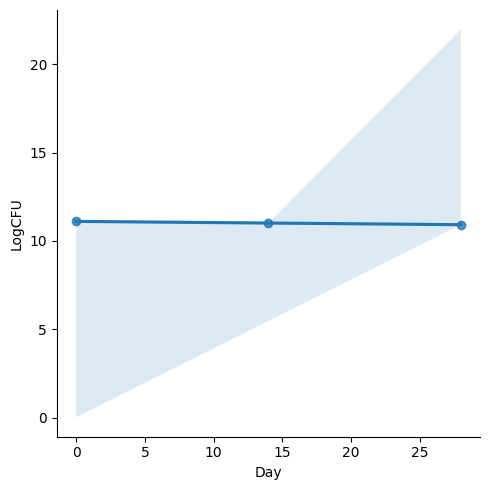

In [60]:
# provide 95%CI grpah
sns.lmplot(x='Day', y='LogCFU', data=a, fit_reg=True, ci=95, n_boot=1000)

**Calcualte 95% CI** in many ways: https://stackoverflow.com/questions/61292464/get-confidence-interval-from-sklearn-linear-regression-in-python

In [78]:
import scipy.stats as sst

In [68]:
X_train = X_a
y_train = y_a

In [80]:
sst.t.interval(alpha=0.95, df=len(y_train)-1, loc=np.mean(y_train), scale=sst.sem(y_train)) 

(10.775801920047382, 11.24084848030354)

In [62]:
alpha = 0.05 # 95% confidence interval
lr = sm.OLS(y_a, sm.add_constant(a['Day'])).fit()
conf_interval = lr.conf_int(alpha)

In [63]:
conf_interval

,0,1
const,11.061805,11.141988
Day,-0.008902,-0.004465


In [88]:
c = unpivot_df[unpivot_df['FD Run ID']=='FDL-105EF-T26-TMC1']
c

,FD Run ID,Day,CFU/g,LogCFU
10,FDL-105EF-T26-TMC1,0,1.013333e+11,11.005752
77,FDL-105EF-T26-TMC1,14,7.853333e+10,10.895054
144,FDL-105EF-T26-TMC1,28,7.262222e+10,10.861070


In [89]:
c['Day'] = c['Day'].astype('float64')

In [90]:
lr_c = sm.OLS(c['LogCFU'], sm.add_constant(c['Day'])).fit()
ci_c = lr_c.conf_int(alpha)

In [92]:
ci_c

,0,1
const,10.629702,11.356231
Day,-0.025266,0.014932


---
Unit test (cont)

In [199]:
def fit_linear_regression(df):
    X = df['Day'].values.reshape(-1,1)
    y = df['LogCFU'].values

    model = LinearRegression()
    model.fit(X,y)
    
    decay_rate = model.coef_[0]
    r_squared = model.score(X, y)
    
    return pd.Series({'Decay Rate': decay_rate, 'R-squared': r_squared})

In [ ]:
y = wegith (day) * day + b

In [200]:
grouped_ids = unpivot_df.groupby('FD Run ID').apply(fit_linear_regression).reset_index()

In [201]:
grouped_ids

,FD Run ID,Decay Rate,R-squared
0,FDL-105B-T10-CC1,-0.006684,0.999318
1,FDL-105B-T10-CC2,-0.006642,0.837602
2,FDL-105B-T10-SKP,-0.007700,1.000000
3,FDL-105B-T10-Try,-0.006590,1.000000
4,FDL-105C-T14-Try,-0.005883,0.848867
5,FDL-105C-T15-SKP,-0.016228,0.992974
6,FDL-105C-T15-Try,-0.017091,0.984521
7,FDL-105D-T20-Try,-0.004865,0.985754
8,FDL-105EF-T22-Try,-0.007318,1.000000
9,FDL-105EF-T24-CC1,-0.014126,0.884324


In [202]:
to_unpivot.shape, unpivot_df.shape, grouped_ids.shape

((67, 6), (118, 4), (56, 3))

In [203]:
# Merge the decay results with the to_unpivot (wide format)
decay_final = pd.merge(left=to_unpivot,right=grouped_ids,on='FD Run ID')
decay_final

,FD Run ID,0,14,28,56,84,Decay Rate,R-squared
0,FDL-105EF-T24-CC1,1.133667e+11,9.563333e+10,4.560000e+10,NaN,NaN,-0.014126,0.884324
1,FDL-105EF-T24-CC2,1.222333e+11,9.056667e+10,4.306667e+10,NaN,NaN,-0.016180,0.943177
2,FDL-105EF-T24-SO1,1.133667e+11,8.043333e+10,4.095556e+10,NaN,NaN,-0.015792,0.965821
3,FDL-105EF-T24-SO2,1.222333e+11,6.396667e+10,3.251111e+10,NaN,NaN,-0.020541,0.999838
4,FDL-105EF-T24-TMC1,1.133667e+11,1.140000e+11,2.989333e+10,NaN,NaN,-0.020675,0.746866
...,...,...,...,...,...,...,...,...
62,FDL-111D-T15-TMC1,1.414444e+11,2.660000e+10,NaN,NaN,NaN,-0.051836,1.000000
63,FDL-111D-T15,1.574889e+11,2.204000e+10,NaN,NaN,NaN,-0.061003,1.000000
64,FDL-105K-T42,3.546667e+10,NaN,7.650667e+09,NaN,NaN,-0.023790,1.000000
65,FDL-105K-T44,6.840000e+10,NaN,2.153333e+09,NaN,NaN,-0.053641,1.000000


In [ ]:
# There is duplicates in 'FD Run ID' after merging (issues: spaces around text - see below)
decay_final.to_csv('decay_test_results.csv',index=False)

In [212]:
decay_final[decay_final.duplicated()]

,FD Run ID,0,14,28,56,84,Decay Rate,R-squared
24,FDL-111EF-T18,8.740000e+10,NaN,NaN,NaN,NaN,0.0,NaN
26,FDL-111EF-T18-CC1TMC1,1.009111e+11,NaN,NaN,NaN,NaN,0.0,NaN
28,FDL-111EF-T18-TMC1,8.444444e+10,NaN,NaN,NaN,NaN,0.0,NaN
30,FDL-111EF-T19,1.089333e+11,NaN,NaN,NaN,NaN,0.0,NaN
32,FDL-111EF-T19-CC1TMC1,1.427111e+11,NaN,NaN,NaN,NaN,0.0,NaN
34,FDL-111EF-T19-TMC1,1.072444e+11,NaN,NaN,NaN,NaN,0.0,NaN
36,FDL-111G-T22,7.304444e+10,NaN,NaN,NaN,NaN,0.0,NaN
38,FDL-111G-T22-CC1TMC1,7.600000e+10,NaN,NaN,NaN,NaN,0.0,NaN
40,FDL-111G-T22-TMC1,6.417778e+10,NaN,NaN,NaN,NaN,0.0,NaN
42,FDL-111G-T23,7.388889e+10,NaN,NaN,NaN,NaN,0.0,NaN


In [213]:
decay_final = decay_final.drop_duplicates()

In [204]:
unpivot_df[unpivot_df['FD Run ID']=='FDL-105B-T10-SKP']

,FD Run ID,Day,CFU/g,LogCFU
150,FDL-105B-T10-SKP,28,6.797778e+10,10.832367
217,FDL-105B-T10-SKP,56,4.137778e+10,10.616767


In [205]:
grouped_ids[grouped_ids['FD Run ID']=='FDL-105B-T10-SKP']

,FD Run ID,Decay Rate,R-squared
2,FDL-105B-T10-SKP,-0.0077,1.0


In [ ]:
# TO-DO: strip the spaces on all values

In [206]:
to_unpivot.loc[to_unpivot['FD Run ID']=='FDL-111EF-T18 ']

,FD Run ID,0,14,28,56,84


In [207]:
to_unpivot.loc[to_unpivot['FD Run ID']=='FDL-111EF-T18']

,FD Run ID,0,14,28,56,84
142,FDL-111EF-T18,8.740000e+10,NaN,NaN,NaN,NaN
174,FDL-111EF-T18,8.740000e+10,NaN,NaN,NaN,NaN


In [208]:
unpivot_df.loc[unpivot_df['FD Run ID']=='FDL-111EF-T18']

,FD Run ID,Day,CFU/g,LogCFU
23,FDL-111EF-T18,0,8.740000e+10,10.941511


In [210]:
grouped_ids.loc[grouped_ids['FD Run ID']=='FDL-111EF-T18']

,FD Run ID,Decay Rate,R-squared
43,FDL-111EF-T18,0.0,NaN


<Axes: >

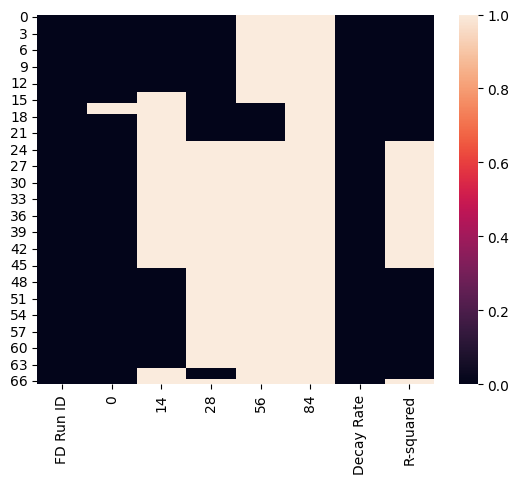

In [100]:
sns.heatmap(decay_final.isnull())

___

### C1. (cont) decay_rate func by Linear Regression

Note: Doesn't need to use the pd.melt(df) for the web app because the raw_df is already in melted form

In [102]:
raw.head()

1,FD Run ID,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV (%),Water Activity,Time point (day),Time point (week)
0,IFF09152022-2 T1,NaN,NaN,21,2023-01-05,2023-02-27,7.410000e+08,1.410000e+10,8.6,0.254,53,8
1,IFF09152022-2 T2,NaN,NaN,21,2023-01-05,2023-02-27,1.970000e+09,3.750000e+10,10.0,0.198,53,8
3,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-03-01,2.300000e+01,4.500000e+00,8.6,NaN,55,8
4,IFF09152022-2 T4,NaN,NaN,21,2023-01-05,2023-02-27,4.550000e+08,8.640000e+09,7.9,0.267,53,8
5,IFF09152022-3 T1,NaN,NaN,21,2023-01-05,2023-02-27,2.440000e+08,4.640000e+09,4.3,0.227,53,8


In [105]:
def decay_rate_lin(df):
    
    # prepare the variables
    df.rename(columns={'Time point (day)':'Day'}, inplace=True)
    df['LogCFU'] = np.log10(df['CFU/g'])
                       
    X = df['Day'].values.reshape(-1,1) #require to reshape, but doesn't have to be float/int
    y = df['LogCFU'].values
    
    # instantiate and fit the model
    model = LinearRegression()
    model.fit(X,y)
    
    decay_rate = model.coef_[0]
    r_squared = model.score(X, y)
    
    return pd.Series({'Decay Rate': decay_rate, 'R-squared': r_squared})

In [ ]:
# TO-DO: groupby from raw, cal decay, join  

# Unit test: test on InPack_CFU_Test.csv file

In [109]:
decay_test = raw.copy()

In [111]:
decay_test.head()

1,FD Run ID,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV (%),Water Activity,Day,Time point (week),LogCFU
0,IFF09152022-2 T1,NaN,NaN,21,2023-01-05,2023-02-27,7.410000e+08,1.410000e+10,8.6,0.254,53,8,10.149219
1,IFF09152022-2 T2,NaN,NaN,21,2023-01-05,2023-02-27,1.970000e+09,3.750000e+10,10.0,0.198,53,8,10.574031
3,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-03-01,2.300000e+01,4.500000e+00,8.6,NaN,55,8,0.653213
4,IFF09152022-2 T4,NaN,NaN,21,2023-01-05,2023-02-27,4.550000e+08,8.640000e+09,7.9,0.267,53,8,9.936514
5,IFF09152022-3 T1,NaN,NaN,21,2023-01-05,2023-02-27,2.440000e+08,4.640000e+09,4.3,0.227,53,8,9.666518


In [117]:
grouped_decay = decay_test.groupby('FD Run ID').apply(decay_rate_lin).reset_index()
grouped_decay

,FD Run ID,Decay Rate,R-squared
0,ABKLUB 030823AA,0.0,NaN
1,ABKLUB 031023AA,0.0,NaN
2,ABKLUB 031323AA,0.0,NaN
3,ABKLUB 031623AA #9,0.0,NaN
4,ABKLUB 031823AA #10,0.0,NaN
...,...,...,...
56,IFF10202022-1 T4,0.0,NaN
57,IFF10202022-2 T1,0.0,NaN
58,IFF10202022-2 T2,0.0,NaN
59,IFF10202022-2 T3,0.0,NaN


In [121]:
grouped_decay[grouped_decay['Decay Rate'] != 0]

,FD Run ID,Decay Rate,R-squared
6,AKLUB 030323 AA,0.013279,1.0
7,AKLUB 030623 AA #5,-0.049469,1.0
8,EDKLUB 022823 03,0.006453,1.0
15,EDKOKO 022823 01,0.093253,1.0


### C2. Use statsmodel 

In [215]:
unpivot_df.head()

,FD Run ID,Day,CFU/g,LogCFU
0,FDL-105EF-T24-CC1,0,1.133667e+11,11.054485
1,FDL-105EF-T24-CC2,0,1.222333e+11,11.087190
2,FDL-105EF-T24-SO1,0,1.133667e+11,11.054485
3,FDL-105EF-T24-SO2,0,1.222333e+11,11.087190
4,FDL-105EF-T24-TMC1,0,1.133667e+11,11.054485


In [216]:
unpivot_df.shape

(118, 4)

In [237]:
c2_test = a.copy()
c2_test

,FD Run ID,Day,CFU/g,LogCFU
6,FDL-105B-T10-CC1,0.0,1.260333e+11,11.100485
73,FDL-105B-T10-CC1,14.0,1.026000e+11,11.011147
140,FDL-105B-T10-CC1,28.0,8.191111e+10,10.913343


*What is sm.add_constant()?*

api , before we fit the model, we need to use the sm. add_constant(X) function, which adds a column of constants to the X dataframe, before passing that into the OLS() function. This is a structural requirement so that the ordinary least squares estimation can be performed properly

In [238]:
c2_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 6 to 140
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FD Run ID  3 non-null      object 
 1   Day        3 non-null      float64
 2   CFU/g      3 non-null      float64
 3   LogCFU     3 non-null      float64
dtypes: float64(3), object(1)
memory usage: 120.0+ bytes


In [239]:
c2_test['Day'] = c2_test['Day'].astype('float64')

In [240]:
# Extract the input features and target variable
X = c2_test['Day']
y = c2_test['LogCFU']

In [241]:
# Add a constant term to the input features 
# Add a column of 1s 
X = sm.add_constant(X)

In [242]:
X

,const,Day
6,1.0,0.0
73,1.0,14.0
140,1.0,28.0


In [243]:
# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

In [247]:
coefficient = results.params[1]
r_squared = results.rsquared

In [248]:
print(coefficient)
print(r_squared)

-0.0066836644833985215
0.9993182217118272


Confirmed the coef and r-squared are the same as Linear Regression model and true results

In [244]:
# Calculate the 95% confidence interval
ci = results.conf_int(alpha=0.05)

In [245]:
# Calculate the error bars
error_bars = ci.diff(axis=1) / 2

In [246]:
# Print the confidence interval and error bars
print("95% Confidence Interval:")
print(ci)
print()
print("Error Bars:")
print(error_bars)

95% Confidence Interval:
               0          1
const  11.061805  11.141988
Day    -0.008902  -0.004465

Error Bars:
        0         1
const NaN  0.040092
Day   NaN  0.002218


*(?) Is not similar to the true inpack_df results*

### C2. (cont) decay_rate func by statsmodel

In [254]:
def decay_rate_statsmodel(df):

    # Extract the input feature and target variable
    X = df['Day'].astype('float64') #require to be float/int
    y = df['LogCFU']
    
    # Add a constant term to the input feature
    X = sm.add_constant(X)
    
    # Fit the linear regression model
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Extract the coefficient and R-squared
    decay_rate = results.params[1]
    r_squared = results.rsquared

    return pd.Series({'Decay Rate': decay_rate, 'R-squared': r_squared})

Unit test: test with unpivot_df and raw df

In [250]:
unpivot_df.head()

,FD Run ID,Day,CFU/g,LogCFU
0,FDL-105EF-T24-CC1,0,1.133667e+11,11.054485
1,FDL-105EF-T24-CC2,0,1.222333e+11,11.087190
2,FDL-105EF-T24-SO1,0,1.133667e+11,11.054485
3,FDL-105EF-T24-SO2,0,1.222333e+11,11.087190
4,FDL-105EF-T24-TMC1,0,1.133667e+11,11.054485


In [258]:
t1 = unpivot_df.groupby('FD Run ID').apply(decay_rate_statsmodel).reset_index()

In [263]:
t1_final = pd.merge(left=to_unpivot,right=t1,on='FD Run ID')
t1_final = t1_final.drop_duplicates()

In [264]:
t1_final.to_csv('t1.csv')

---

# Joining with In-pack Analysis

## A. Structure of final In-pack report TO ACHIEVE

In [20]:
inpack_df = pd.read_excel("/Users/miu/IFF_st/Data files/PIVOT Sample Master List 2023_10May23.xlsm", sheet_name='WP4 In-pack Data')
inpack_df.head()

,Unique ID,FD sample ID,FD Run ID,Strain,Cryo mix,Sub-Sample,Ferm Condition,Storage form,Temperature (°C),Container,...,Rsquared_fitted,decay_rate_errbar,decay_rate_lower95interval,decay_rate_upper95interval,estimate_day_2e10,Week 0 Aw,Week 2 Aw,Week 4 Aw,Week 8 Aw,Week 12 Aw
0,1.0,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,pellet_21_mylar_n,"Greens, high EPS",Pellet,21,Mylar,...,0.996659,0.000881,-0.008642,-0.006880,168.374192,0.165,NaN,0.175,0.205,NaN
1,2.0,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,pellet_21_mylar_cacl2,"Greens, high EPS",Pellet,21,Mylar,...,0.939662,0.005588,-0.016840,-0.005663,116.142074,0.165,NaN,0.125,0.153,NaN
2,3.0,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,unbulked powder_21_mylar_n,"Greens, high EPS",Unbulked powder,21,Mylar,...,0.990339,0.002946,-0.018166,-0.012273,85.502213,0.289,NaN,0.23,0.268,NaN
3,4.0,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,"bulked powder, pre-dried bulking_21_mylar_n","Greens, high EPS","Bulked powder, pre-dried bulking",21,Mylar,...,0.993116,0.001788,-0.012742,-0.009167,88.342199,0.224,NaN,0.174,0.221,NaN
4,5.0,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,"bulked powder, w/o sio2_21_mylar_n","Greens, high EPS","Bulked powder, w/o SiO2",21,Mylar,...,0.998539,0.001091,-0.015640,-0.013459,73.940614,0.229,NaN,0.21,0.257,NaN


In [21]:
inpack_df.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['Unique ID', 'FD sample ID', 'FD Run ID', 'Strain', 'Cryo mix',
       'Sub-Sample', 'Ferm Condition', 'Storage form', 'Temperature (°C)',
       'Container', 'Bulking', 'Desiccant', 'Quantity (g)', 'Sample location',
       'Week 0 CFU/g', 'Week 2 CFU/g', 'Week 4 CFU/g', 'Week 8 CFU/g',
       'Week 12 CFU/g', 'decay_rate_fitted', 'Rsquared_fitted',
       'decay_rate_errbar', 'decay_rate_lower95interval',
       'decay_rate_upper95interval', 'estimate_day_2e10', 'Week 0 Aw',
       'Week 2 Aw', 'Week 4 Aw', 'Week 8 Aw', 'Week 12 Aw'],
      dtype='object')>

In [22]:
inpack_df.drop(['Unique ID','Quantity (g)','Sample location','Week 0 Aw',
                'Week 2 Aw', 'Week 4 Aw', 'Week 8 Aw', 'Week 12 Aw'],axis=1,inplace=True)

*In-pack* available features:
- Key: FD Run ID
- CFU values by week
- Water activity by week

**Features carry** to *In-pack*:
- Key: **'FD Run ID'** 
- Cols: 'Strain','FD Recipe', 'Cryo mix','Ferm condition','Container', 

**User Inputs** for 'In-pack' (create a new form/table, different from the Sample Info table):
- 'Temperature (°C)', 'Container', 'Bulking', 'Desiccant', 'Storage form'
    
    Note:
    - Ferm condition: shorten the description from the "Info"
    
**Features to calculate**
- sub-sample: generated from storage form, temp, container, desciccant
- 'decay_rate_fitted', 'Rsquared_fitted','decay_rate_errbar', 'decay_rate_lower95interval', 'decay_rate_upper95interval', 'estimate_day_2e10'

In [23]:
inpack_df.head()

,FD sample ID,FD Run ID,Strain,Cryo mix,Sub-Sample,Ferm Condition,Storage form,Temperature (°C),Container,Bulking,...,Week 2 CFU/g,Week 4 CFU/g,Week 8 CFU/g,Week 12 CFU/g,decay_rate_fitted,Rsquared_fitted,decay_rate_errbar,decay_rate_lower95interval,decay_rate_upper95interval,estimate_day_2e10
0,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,pellet_21_mylar_n,"Greens, high EPS",Pellet,21,Mylar,PVT,...,NaN,2.584000e+11,1.490000e+11,NaN,-0.007761,0.996659,0.000881,-0.008642,-0.006880,168.374192
1,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,pellet_21_mylar_cacl2,"Greens, high EPS",Pellet,21,Mylar,PVT,...,NaN,2.698000e+11,9.500000e+10,NaN,-0.011252,0.939662,0.005588,-0.016840,-0.005663,116.142074
2,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,unbulked powder_21_mylar_n,"Greens, high EPS",Unbulked powder,21,Mylar,PVT,...,NaN,1.774600e+11,5.624000e+10,NaN,-0.015220,0.990339,0.002946,-0.018166,-0.012273,85.502213
3,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,"bulked powder, pre-dried bulking_21_mylar_n","Greens, high EPS","Bulked powder, pre-dried bulking",21,Mylar,PVT,...,NaN,1.014600e+11,4.522000e+10,NaN,-0.010955,0.993116,0.001788,-0.012742,-0.009167,88.342199
4,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,"bulked powder, w/o sio2_21_mylar_n","Greens, high EPS","Bulked powder, w/o SiO2",21,Mylar,PVT,...,NaN,9.918000e+10,3.648000e+10,NaN,-0.014549,0.998539,0.001091,-0.015640,-0.013459,73.940614


## B. Dataset Preparation

In [11]:
# Sample info
master_lst = pd.read_csv('sample_info.csv')

In [12]:
master_lst.head()

,FD sample ID,FD Run ID,Strain,EFT date,Broth ID,Fermentation Scale,Ferm condition,EFT (hr),Broth titer (CFU/mL),Broth age (day),...,FD run time (hr),Primary ramp rate (C/min),PA receive date,Dried appearance,Container,Water activity,Viability (CFU/g),Cryo mix Coef,Yield (%),Log Loss
0,22PT1202-10,FDL-105A-T01,Klebsiella variicola,2022-12-01,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,3.540000e+11,1.0,...,57.0,NaN,2022-12-20 00:00:00,fused/melted moist cake,Foil pouch,0.37,NaN,0.380,NaN,NaN
1,22PT1202-12,FDL-105A-T02,Klebsiella variicola,2022-12-01,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,3.540000e+11,1.0,...,57.0,NaN,2022-12-20 00:00:00,"Collapse, no dust",Foil pouch,0.06,1.840000e+11,0.342,17.78,-0.75
2,22PT1202-5,FDL-105A-T03,Kosakonia sacchari,2022-12-01,P080-22-Y046,14L,"Potato peptone and tryptone, high viscosity by...",48.0,1.180000e+11,1.0,...,57.0,NaN,2022-12-20 00:00:00,"Collapse, some dust",Foil pouch,0.24,6.610000e+10,0.285,15.96,-0.80
3,22PT1202-11,FDL-105A-T04,Klebsiella variicola,2022-12-01,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,3.540000e+11,1.0,...,57.0,NaN,2022-12-20 00:00:00,"Collapse, no dust",Foil pouch,0.05,3.150000e+11,0.285,25.36,-0.60
4,22PT1202-1,FDL-105B-T05,Kosakonia sacchari,2022-12-01,P080-22-Y046,14L,"Potato peptone and tryptone, low viscosity",48.0,1.180000e+11,1.0,...,57.0,NaN,2022-12-22 00:00:00,"friable cake, readily broke into pellets",Foil pouch,0.42,4.070000e+10,0.380,13.11,-0.88


In [13]:
master_lst.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['FD sample ID', 'FD Run ID', 'Strain', 'EFT date', 'Broth ID',
       'Fermentation Scale', 'Ferm condition', 'EFT (hr)',
       'Broth titer (CFU/mL)', 'Broth age (day)', 'Pelletization date',
       'Cryo mix', 'Ingredient 1', 'Ingredient 2', 'Ingredient 3',
       'Cryo mix addition rate', 'FD start date', 'FD cycle recipe',
       'FD pressure (mTorr)', 'FD run time (hr)', 'Primary ramp rate (C/min)',
       'PA receive date', 'Dried appearance', 'Container', 'Water activity',
       'Viability (CFU/g)', 'Cryo mix Coef', 'Yield (%)', 'Log Loss'],
      dtype='object')>

**INFO from Master list TO MERGE**

In [14]:
info_df = master_lst[['FD sample ID', 'FD Run ID', 'FD cycle recipe', 'Strain','Ferm condition','Cryo mix']]

In [15]:
info_df.head(10)

,FD sample ID,FD Run ID,FD cycle recipe,Strain,Ferm condition,Cryo mix
0,22PT1202-10,FDL-105A-T01,PVT090-A0,Klebsiella variicola,"Potato peptone and tryptone, high viscosity by...",SKP
1,22PT1202-12,FDL-105A-T02,PVT090-A0,Klebsiella variicola,"Potato peptone and tryptone, high viscosity by...",DSR
2,22PT1202-5,FDL-105A-T03,PVT090-A0,Kosakonia sacchari,"Potato peptone and tryptone, high viscosity by...",PVT70%
3,22PT1202-11,FDL-105A-T04,PVT090-A0,Klebsiella variicola,"Potato peptone and tryptone, high viscosity by...",PVT70%
4,22PT1202-1,FDL-105B-T05,PVT090-A0,Kosakonia sacchari,"Potato peptone and tryptone, low viscosity",SKP
5,22PT1202-3,FDL-105B-T06,PVT090-A0,Kosakonia sacchari,"Potato peptone and tryptone, low viscosity",DSR
6,22PT1202-4,FDL-105B-T07,PVT090-A0,Kosakonia sacchari,"Potato peptone and tryptone, high viscosity by...",SKP
7,22PT1117-7,FDL-105B-T08,PVT090-A0,Klebsiella variicola,"Potato peptone and tryptone, low viscosity",SKP
8,22PT1202-6,FDL-105B-T09,PVT090-A0,Kosakonia sacchari,"Potato peptone and tryptone, high viscosity by...",DSR
9,22PT1117-8,FDL-105B-T10,PVT090-A0,Klebsiella variicola,"Potato peptone and tryptone, low viscosity",PVT70%


In [16]:
info_df['Ferm condition'] = info_df['Ferm condition'].apply(lambda x:x.strip())

**In-pack CFU TO MERGE**

In [15]:
cfu_df = clean.drop(['T0','Date'],axis=1)

In [16]:
cfu_df.head()

,FD Run ID,W0_CFU/mL,W1_CFU/mL,W8_CFU/mL,W0_CFU/g,W1_CFU/g,W8_CFU/g,W0_Water Activity,W1_Water Activity,W8_Water Activity
0,IFF09152022-2 T1,NaN,NaN,7.410000e+08,NaN,NaN,1.410000e+10,NaN,NaN,0.254
1,IFF09152022-2 T2,NaN,NaN,1.970000e+09,NaN,NaN,3.750000e+10,NaN,NaN,0.198
2,IFF09152022-2 T3,NaN,NaN,2.300000e+01,NaN,NaN,4.500000e+00,NaN,NaN,NaN
3,IFF09152022-2 T4,NaN,NaN,4.550000e+08,NaN,NaN,8.640000e+09,NaN,NaN,0.267
4,IFF09152022-3 T1,NaN,NaN,2.440000e+08,NaN,NaN,4.640000e+09,NaN,NaN,0.227


**In-pack USER INPUT TO MERGE**

In [17]:
cols = ['FD sample ID', 'FD Run ID','Storage form','Container','Temperature (°C)','Bulking','Desiccant']
real_input_df = inpack_df[cols]

In [18]:
real_input_df.head()

,FD sample ID,FD Run ID,Storage form,Container,Temperature (°C),Bulking,Desiccant
0,IFF09152022-1,FDL-099A,Pellet,Mylar,21,PVT,N
1,IFF09152022-1,FDL-099A,Pellet,Mylar,21,PVT,2%CaCl2
2,IFF09152022-1,FDL-099A,Unbulked powder,Mylar,21,PVT,5%SIO2
3,IFF09152022-1,FDL-099A,"Bulked powder, pre-dried bulking",Mylar,21,PVT,5%SIO2
4,IFF09152022-1,FDL-099A,"Bulked powder, w/o SiO2",Mylar,21,PVT,5%SIO2


In [20]:
real_input_df['Desiccant'].unique()

array(['N', '2%CaCl2', '5%SIO2', '10%CaCl2', '10%SIO2', '25%SIO2',
       '5%TMC', '25%TMC', '10%TMC', '5%TMC+2%CaCl2', '2% CaCl2',
       '5%TMC+2% CaCl2', nan], dtype=object)

In [74]:
# Naming issue
## There weren't unique IDs on on the historical dataset
cfu_df.loc[cfu_df['FD Run ID']=="FDL-099A"]

,FD Run ID,W0_CFU/mL,W1_CFU/mL,W3_CFU/mL,W4_CFU/mL,W8_CFU/mL,W0_CFU/g,W1_CFU/g,W3_CFU/g,W4_CFU/g,W8_CFU/g,W0_Water Activity,W1_Water Activity,W3_Water Activity,W4_Water Activity,W8_Water Activity


In [78]:
cfu_df.loc[cfu_df['FD Run ID']=="FDL-111A-T2"]

,FD Run ID,W0_CFU/mL,W1_CFU/mL,W3_CFU/mL,W4_CFU/mL,W8_CFU/mL,W0_CFU/g,W1_CFU/g,W3_CFU/g,W4_CFU/g,W8_CFU/g,W0_Water Activity,W1_Water Activity,W3_Water Activity,W4_Water Activity,W8_Water Activity
36,FDL-111A-T2,8.670000e+09,NaN,NaN,NaN,NaN,1.650000e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
cfu_df.loc[cfu_df['FD Run ID'].str.contains("FDL-111A-T2")]['FD Run ID'].str.split("-")

36            [FDL, 111A, T2]
41    [FDL, 111A, T2 5% SiO2]
44       [FDL, 111A, T2 TMC1]
Name: FD Run ID, dtype: object

In [97]:
a = "FDL-111A-T2-TMC1"
b = "FDL-111A T2 TMC1"
c = "FDL-111A-T2"
d = "FDL-111A T2 TMC2"

In [ ]:
from thefuzz import fuzz

In [99]:
fuzz.ratio(b, d)

94

In [94]:
fuzz.ratio(a, c)

81

In [95]:
fuzz.ratio(b, c)

74

In [96]:
fuzz.ratio(b, a)

88

? How many `FD Run ID` from cfu_df are recorded in the real_input_df?

In [75]:
same_run_id = real_input_df[real_input_df['FD Run ID'].isin(cfu_df['FD Run ID'])]

In [76]:
same_run_id

,FD sample ID,FD Run ID,Storage form,Container,Temperature (°C),Bulking,Desiccant
154,23PT0227-4,FDL-111A-T2,Bulked powder,Mylar,21,PVT,5%SIO2
157,23PT0227-6,FDL-111A-T3,Bulked powder,Mylar,21,PVT,5%SIO2
160,23PT0227-8,FDL-111A-T4,Bulked powder,Mylar,21,PVT,5%SIO2
168,23PT0227-4,FDL-111D-T14,Bulked powder,Mylar,21,PVT,5%SIO2
171,23PT0227-6,FDL-111D-T15,Bulked powder,Mylar,21,PVT,5%SIO2
172,23PT0126-2,FDL-105K-T42,Bulked powder,Mylar,21,PVT,5%SIO2
173,23PT0126-5,FDL-105K-T44,Bulked powder,Mylar,21,PVT,5%SIO2


In [77]:
same_run_id.shape

(7, 7)

In [61]:
a = info_df[info_df['FD sample ID'].isin(same_run_id['FD sample ID'])]

In [62]:
a

,FD sample ID,FD Run ID,FD cycle recipe,Strain,Ferm condition,Cryo mix
43,23PT0126-2,FDL-105K-T42,PVT380,Kosakonia sacchari,"Tryptone + potato peptone, lower top feed rate...",PVT70%
45,23PT0126-5,FDL-105K-T44,PVT380,Kosakonia sacchari,"tryptone + potato peptone, low top feed rate, ...",PVT70%
63,23PT0227-4,FDL-111A-T02,PVT380,Kosakonia sacchari,Tryptone only,PVT70%
64,23PT0227-6,FDL-111A-T03,PVT380,Kosakonia sacchari,Peptone only,PVT70%
65,23PT0227-8,FDL-111A-T04,PVT380,Kosakonia sacchari,"Peptone only, upconcentrated",PVT70%
66,23PT0227-8,FDL-111B-T08,ESL1010,Kosakonia sacchari,"Peptone only, upconcentrated",PVT70%
67,23PT0227-4,FDL-111C-T10,ESL1020,Kosakonia sacchari,Tryptone only,PVT70%
68,23PT0227-6,FDL-111C-T11,ESL1020,Kosakonia sacchari,Peptone only,PVT70%
69,23PT0227-8,FDL-111C-T12,ESL1020,Kosakonia sacchari,"Peptone only, upconcentrated",PVT70%
71,23PT0227-4,FDL-111D-T14,ESL1130,Kosakonia sacchari,Tryptone only,PVT70%


In [27]:
info_df.shape, real_input_df.shape, cfu_df.shape

((97, 6), (187, 7), (61, 10))

## C. Join the Dataframes

1. real_input_df + cfu_df ON 'FD Run ID' = A
2. A + info_df ON 'FD sample ID' = B

**NOTE**

MUST have the USER INPUT of *"FD sample ID"* to merge the dfs, because 
- cfu_df doesn't have FD sample ID
- info_df doesn't contain all the FD Run ID

Thus, can't merge on FD Run ID from these 2 dfs. 

In [36]:
temp1 = pd.merge(left=cfu_df, right=real_input_df, on='FD Run ID')

In [37]:
temp1

,FD Run ID,W0_CFU/mL,W1_CFU/mL,W8_CFU/mL,W0_CFU/g,W1_CFU/g,W8_CFU/g,W0_Water Activity,W1_Water Activity,W8_Water Activity,FD sample ID,Storage form,Container,Temperature (°C),Bulking,Desiccant
0,FDL-111A-T2,8.670000e+09,NaN,NaN,1.650000e+11,NaN,NaN,NaN,NaN,NaN,23PT0227-4,Bulked powder,Mylar,21,PVT,5%SIO2
1,FDL-111A-T3,1.240000e+10,NaN,NaN,2.360000e+11,NaN,NaN,NaN,NaN,NaN,23PT0227-6,Bulked powder,Mylar,21,PVT,5%SIO2
2,FDL-111A-T4,1.380000e+10,NaN,NaN,2.620000e+11,NaN,NaN,NaN,NaN,NaN,23PT0227-8,Bulked powder,Mylar,21,PVT,5%SIO2
3,FDL-111D-T14,1.490000e+10,NaN,NaN,2.840000e+11,NaN,NaN,NaN,NaN,NaN,23PT0227-4,Bulked powder,Mylar,21,PVT,5%SIO2
4,FDL-111D-T15,1.990000e+10,NaN,NaN,3.770000e+11,NaN,NaN,NaN,NaN,NaN,23PT0227-6,Bulked powder,Mylar,21,PVT,5%SIO2
5,FDL-105K-T42,4.030000e+08,NaN,NaN,7.650000e+09,NaN,NaN,NaN,NaN,NaN,23PT0126-2,Bulked powder,Mylar,21,PVT,5%SIO2
6,FDL-105K-T44,1.130000e+08,NaN,NaN,2.150000e+09,NaN,NaN,NaN,NaN,NaN,23PT0126-5,Bulked powder,Mylar,21,PVT,5%SIO2


In [ ]:
# arrange cols 
temp1 = temp1[['FD sample ID','FD Run ID','Strain', 'Ferm condition','Cryo mix',
             'W0_CFU/mL', 'W1_CFU/mL', 'W8_CFU/mL', 'W0_CFU/g',
             'W1_CFU/g', 'W8_CFU/g', 'W0_Water Activity', 'W1_Water Activity','W8_Water Activity']]

### To Work on

In [41]:
temp2 = pd.merge(right=temp1, left=info_df.drop(['FD Run ID'], axis=1), on='FD sample ID')

In [42]:
temp2

,FD sample ID,Strain,Ferm condition,Cryo mix,FD Run ID,W0_CFU/mL,W1_CFU/mL,W8_CFU/mL,W0_CFU/g,W1_CFU/g,W8_CFU/g,W0_Water Activity,W1_Water Activity,W8_Water Activity,Storage form,Container,Temperature (°C),Bulking,Desiccant
0,23PT0126-2,Kosakonia sacchari,"Tryptone + potato peptone, lower top feed rate...",PVT70%,FDL-105K-T42,4.030000e+08,NaN,NaN,7.650000e+09,NaN,NaN,NaN,NaN,NaN,Bulked powder,Mylar,21,PVT,5%SIO2
1,23PT0126-5,Kosakonia sacchari,"tryptone + potato peptone, low top feed rate, ...",PVT70%,FDL-105K-T44,1.130000e+08,NaN,NaN,2.150000e+09,NaN,NaN,NaN,NaN,NaN,Bulked powder,Mylar,21,PVT,5%SIO2
2,23PT0227-4,Kosakonia sacchari,Tryptone only,PVT70%,FDL-111A-T2,8.670000e+09,NaN,NaN,1.650000e+11,NaN,NaN,NaN,NaN,NaN,Bulked powder,Mylar,21,PVT,5%SIO2
3,23PT0227-4,Kosakonia sacchari,Tryptone only,PVT70%,FDL-111D-T14,1.490000e+10,NaN,NaN,2.840000e+11,NaN,NaN,NaN,NaN,NaN,Bulked powder,Mylar,21,PVT,5%SIO2
4,23PT0227-4,Kosakonia sacchari,Tryptone only,PVT70%,FDL-111A-T2,8.670000e+09,NaN,NaN,1.650000e+11,NaN,NaN,NaN,NaN,NaN,Bulked powder,Mylar,21,PVT,5%SIO2
5,23PT0227-4,Kosakonia sacchari,Tryptone only,PVT70%,FDL-111D-T14,1.490000e+10,NaN,NaN,2.840000e+11,NaN,NaN,NaN,NaN,NaN,Bulked powder,Mylar,21,PVT,5%SIO2
6,23PT0227-4,Kosakonia sacchari,Tryptone only,PVT70%,FDL-111A-T2,8.670000e+09,NaN,NaN,1.650000e+11,NaN,NaN,NaN,NaN,NaN,Bulked powder,Mylar,21,PVT,5%SIO2
7,23PT0227-4,Kosakonia sacchari,Tryptone only,PVT70%,FDL-111D-T14,1.490000e+10,NaN,NaN,2.840000e+11,NaN,NaN,NaN,NaN,NaN,Bulked powder,Mylar,21,PVT,5%SIO2
8,23PT0227-4,Kosakonia sacchari,Tryptone only,PVT70%,FDL-111A-T2,8.670000e+09,NaN,NaN,1.650000e+11,NaN,NaN,NaN,NaN,NaN,Bulked powder,Mylar,21,PVT,5%SIO2
9,23PT0227-4,Kosakonia sacchari,Tryptone only,PVT70%,FDL-111D-T14,1.490000e+10,NaN,NaN,2.840000e+11,NaN,NaN,NaN,NaN,NaN,Bulked powder,Mylar,21,PVT,5%SIO2


In [36]:
temp.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['FD Run ID', 'W0_CFU/mL', 'W1_CFU/mL', 'W8_CFU/mL', 'W0_CFU/g',
       'W1_CFU/g', 'W8_CFU/g', 'W0_Water Activity', 'W1_Water Activity',
       'W8_Water Activity', 'FD sample ID', 'Strain', 'Ferm condition',
       'Cryo mix'],
      dtype='object')>

In [38]:
# Re-arrange the columns
temp = temp[['FD sample ID','FD Run ID','Strain', 'Ferm condition','Cryo mix',
             'W0_CFU/mL', 'W1_CFU/mL', 'W8_CFU/mL', 'W0_CFU/g',
             'W1_CFU/g', 'W8_CFU/g', 'W0_Water Activity', 'W1_Water Activity','W8_Water Activity']]

In [40]:
temp

,FD sample ID,FD Run ID,Strain,Ferm condition,Cryo mix,W0_CFU/mL,W1_CFU/mL,W8_CFU/mL,W0_CFU/g,W1_CFU/g,W8_CFU/g,W0_Water Activity,W1_Water Activity,W8_Water Activity
0,23PT0227-4,FDL-111C-T10,Kosakonia sacchari,Tryptone only,PVT70%,7.600000e+09,NaN,NaN,1.440000e+11,NaN,NaN,NaN,NaN,NaN
1,23PT0227-6,FDL-111C-T11,Kosakonia sacchari,Peptone only,PVT70%,1.440000e+10,NaN,NaN,2.740000e+11,NaN,NaN,NaN,NaN,NaN
2,23PT0227-8,FDL-111C-T12,Kosakonia sacchari,"Peptone only, upconcentrated",PVT70%,1.460000e+10,NaN,NaN,2.770000e+11,NaN,NaN,NaN,NaN,NaN
3,IFF12282022-10,FDL-111D-T13,Kosakonia sacchari,Glucose,PVT70%,1.590000e+10,NaN,NaN,3.010000e+11,NaN,NaN,NaN,NaN,NaN
4,23PT0227-4,FDL-111D-T14,Kosakonia sacchari,Tryptone only,PVT70%,1.490000e+10,NaN,NaN,2.840000e+11,NaN,NaN,NaN,NaN,NaN
5,23PT0227-6,FDL-111D-T15,Kosakonia sacchari,Peptone only,PVT70%,1.990000e+10,NaN,NaN,3.770000e+11,NaN,NaN,NaN,NaN,NaN
6,23PT0227-8,FDL-111D-T16,Kosakonia sacchari,"Peptone only, upconcentrated",PVT70%,9.920000e+09,NaN,NaN,1.880000e+11,NaN,NaN,NaN,NaN,NaN
7,23PT0126-2,FDL-105K-T42,Kosakonia sacchari,"Tryptone + potato peptone, lower top feed rate...",PVT70%,4.030000e+08,NaN,NaN,7.650000e+09,NaN,NaN,NaN,NaN,NaN
8,23PT0126-5,FDL-105K-T44,Kosakonia sacchari,"tryptone + potato peptone, low top feed rate, ...",PVT70%,1.130000e+08,NaN,NaN,2.150000e+09,NaN,NaN,NaN,NaN,NaN


In [17]:
# TODO: change 'FD cycle recipe' -> 'FD recipe'
info_df.rename(columns={'FD cycle recipe':'FD recipe'}, inplace=True)

In [ ]:
# TODO: mapping dictionary for 'Ferm condition'
# e.g.: {Peptone only}:['P only']

In [18]:
info_df['Ferm condition'].value_counts()

Tryptone+Peptone                                                                11
Glucose, no EPS, CR                                                             10
Glucose                                                                         10
Peptone only, upconcentrated                                                     7
Tryptone only                                                                    7
Peptone only                                                                     6
Potato peptone and tryptone, low viscosity                                       6
Potato peptone and tryptone, high viscosity by post-ferm addition of 0.7% XG     6
tryptone only                                                                    6
Glucose, high EPS, CR                                                            6
repeat of P080-22-Y007, tryptone + potato peptone                                3
Tryptone + potato peptone, lower top feed rate, no EPS                           3
tryp

In [24]:
inpack_df['Ferm Condition'].value_counts()

T only               41
P only               29
T+P, no EPS          25
T+P, 0.7% XG         22
Glucose, no EPS      19
T+P, high EPS        19
Greens, high EPS     15
Glucose, high EPS     9
P only, con           6
T+P                   1
Name: Ferm Condition, dtype: int64

In [ ]:
mapping_ferm_cond = {
    'Tryptone+Peptone': ['T+P'],
    'Tryptone only': ['T only'],
    'Glucose': ['Glucose, no EPS'],
    'Glucose, no EPS, CR': ['Glucose, no EPS'],
    'Peptone only, upconcentrated': ['P only, con'],
    'Potato peptone and tryptone, high viscosity by post-ferm addition of 0.7% XG': ['T+P, 0.7% XG'],
    'Peptone only': ['P only'],
    'Potato peptone and tryptone, low viscosity': ['T+P'],
    'Glucose, high EPS, CR': ['Glucose, high EPS'],
    'tryptone only': ['T only'],
    'repeat of P080-22-Y007, tryptone + potato peptone': ['T+P'],
    'Tryptone + potato peptone, lower top feed rate, no EPS': ['T+P'],
    'tryptone + potato peptone, low top feed rate, no EPS, w 0.7% XG': ['T+P, 0.7% XG'],
    'repeat of P080-22-Y005, tryptone + potato peptone': ['T+P'],
    'Potato peptone only, less EPS, pH control': ['P only'],
    'Glucose, no EPS': ['Glucose, no EPS'],
    'Glucose, high EPS, CR broth': ['Glucose, high EPS'],
    'Greens': ['Greens, high EPS'],
    'Glucose, high EPS': ['Glucose, no EPS']
}

## Appendices

**Tranpose columns to rows**

In [19]:
# create a sample dataframe
data = {'Name': ['John', 'Mary', 'Peter'],
        'Age': [25, 30, 35],
        'Salary_2019': [50000, 60000, 70000],
        'Salary_2020': [55000, 65000, 75000],
        'Salary_2021': [60000, 70000, 80000]}

df = pd.DataFrame(data)

# melt the data to transpose columns to rows
melted_df = pd.melt(df, id_vars=['Name', 'Age'], var_name='Year', value_name='Salary')

# print the transposed dataframe
print(melted_df)

    Name  Age         Year  Salary
0   John   25  Salary_2019   50000
1   Mary   30  Salary_2019   60000
2  Peter   35  Salary_2019   70000
3   John   25  Salary_2020   55000
4   Mary   30  Salary_2020   65000
5  Peter   35  Salary_2020   75000
6   John   25  Salary_2021   60000
7   Mary   30  Salary_2021   70000
8  Peter   35  Salary_2021   80000


In [20]:
df

,Name,Age,Salary_2019,Salary_2020,Salary_2021
0,John,25,50000,55000,60000
1,Mary,30,60000,65000,70000
2,Peter,35,70000,75000,80000


**Tranpose rows to columns**

In [22]:
# create a sample dataframe
data = {'Name': ['John', 'Mary', 'Peter'],
        'Year': [2019, 2020, 2021],
        'Salary': [50000, 60000, 70000]}

df1 = pd.DataFrame(data)

# pivot the data to transpose rows to columns
pivoted_df = df1.pivot(index='Name', columns='Year', values='Salary')

# print the transposed dataframe
print(pivoted_df)

Year      2019     2020     2021
Name                            
John   50000.0      NaN      NaN
Mary       NaN  60000.0      NaN
Peter      NaN      NaN  70000.0


In [23]:
df1

,Name,Year,Salary
0,John,2019,50000
1,Mary,2020,60000
2,Peter,2021,70000


In [12]:
import pandas as pd

# Create a sample DataFrame and pivot table
df = pd.DataFrame({'A': [1, 2, 3], 'B': ['a', 'b', 'c']}, index=['X', 'Y', 'Z'])
pivot_table = pd.pivot_table(df, values='A', index='B', aggfunc='sum')

# Join the pivot table with the original DataFrame
joined_df = df.join(pivot_table, on='B', rsuffix='_sum')

# Display the joined DataFrame
print(joined_df)

   A  B  A_sum
X  1  a      1
Y  2  b      2
Z  3  c      3


In [13]:
df

,A,B
X,1,a
Y,2,b
Z,3,c


In [14]:
pivot_table

,A
B,
a,1
b,2
c,3


In [75]:
import pandas as pd

# create a pivot table
df_pivot = pd.DataFrame({'A': ['foo', 'foo', 'bar', 'bar', 'foo', 'foo', 'bar', 'bar'],
                         'B': ['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two'],
                         'C': [1, 2, 3, 4, 5, 6, 7, 8],
                         'D': [10, 20, 30, 40, 50, 60, 70, 80]}).pivot_table(index='A', columns='B', values='C')

# create a regular DataFrame
df_normal = pd.DataFrame({'A': ['foo', 'bar', 'baz'], 'E': [100, 200, 300]})

# reset the index of the pivot DataFrame
df_pivot = df_pivot.reset_index()

# join the two DataFrames on the 'A' column
df_merged = pd.merge(df_pivot, df_normal, on='A')

print(df_merged)

     A  one  two    E
0  bar    5    6  200
1  foo    3    4  100


In [76]:
df_pivot

B,A,one,two
0,bar,5,6
1,foo,3,4


In [77]:
df_normal

,A,E
0,foo,100
1,bar,200
2,baz,300


**statsmodel library**

In [310]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [320]:
a

,FD Run ID,Day,CFU/g,LogCFU
6,FDL-105B-T10-CC1,0,1.260333e+11,11.100485
73,FDL-105B-T10-CC1,14,1.026000e+11,11.011147
140,FDL-105B-T10-CC1,28,8.191111e+10,10.913343


In [324]:
a['Day'] = a['Day'].astype('float64')

In [325]:
a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 6 to 140
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FD Run ID  3 non-null      object 
 1   Day        3 non-null      float64
 2   CFU/g      3 non-null      float64
 3   LogCFU     3 non-null      float64
dtypes: float64(3), object(1)
memory usage: 120.0+ bytes


In [329]:
X = a['Day']
y = a['LogCFU']

In [ ]:
# Assuming you have a DataFrame called 'df' with columns 'X' and 'Y'
df = pd.DataFrame({'X': [1, 2, 3, 4, 5], 'Y': [2, 4, 5, 4, 5]})

# Extract the input features and target variable
X = df['X']
y = df['Y']

# Add a constant term to the input features
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Calculate the predicted values
predictions = results.predict(X)

# Calculate the 95% confidence interval
ci = results.conf_int(alpha=0.05)

# Calculate the error bars
error_bars = ci.diff(axis=1) / 2

# Print the confidence interval and error bars
print("95% Confidence Interval:")
print(ci)
print()
print("Error Bars:")
print(error_bars)
